## 1) Library & Data Import

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/tripadviser_review.csv")

In [3]:
df.head()

,rating,text
0,4,여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...
1,4,"2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입..."
2,4,지인에소개로온 호텔 깨끗하고 좋은거같아요 처음에는 없는게 많아 많이 당황했는데 ...
3,5,방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...
4,5,저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...


#### Feature Description
- rating : 이용자 리뷰의 평가 점수
- text : 이용자 리뷰 평가 내용

-----

## 2) 데이터셋 살펴보기

### 2-1) 기본 정보 탐색

##### 데이터셋 기본 정보 탐색

In [4]:
df.shape

(1001, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  1001 non-null   int64 
 1   text    1001 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [6]:
df.isnull().sum()

rating    0
text      0
dtype: int64

In [7]:
df['text'][0]

'여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 편이었고 청소나 청결상태도 좋았습니다.'

In [8]:
df['text'][100]

'올 봄에 벚꽃기간에 방문, 협재를 바라보는 바다뷰가 좋고 대로변이라 렌트해서 가기도 좋음. 조식은 이용안했는데 근처 옹포밥집까지 아침 산책겸 걸어가서 하고옴. 루프탑 수영장과 바가 있었는데 내가 갔을때는 밤에 비바람이 너무 불어서 이용못하고옴 ㅠㅠ  단점으로는 모 유명 여행블로거 리뷰처럼 화장실 물떄가... 그거빼곤 다 만족'

In [9]:
len(df['text'].values.sum())

223576

-----

## 3) 한국어 텍스트 데이터 전처리

### 3-0) konlpy 설치

In [10]:
# konlpy 0.5.2의 JVM 버그로 인해, 0.5.1 버전으로 install
# !pip install konlpy==0.6.0 jpype1 Jpype1-py3


### 3-1) 정규표현식 적용

In [11]:
import re

def apply_regular_expression(text):
  hangul = re.compile('[^ ㄱ-ㅣ가-힣]')
  result = hangul.sub('', text)
  return result

In [12]:
apply_regular_expression(df['text'][0])

'여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다 위치선정 또한 적당한 편이었고 청소나 청결상태도 좋았습니다'

In [13]:
df['text'][0]

'여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 편이었고 청소나 청결상태도 좋았습니다.'

-----

### 3-2) 한국어 형태소분석 - 명사 단위

##### 명사 형태소 추출

In [14]:
from konlpy.tag import Okt
from collections import Counter


# noun = 명사
# tolist()는 배열(array)로 선언된 변수를 list형식으로 바꿔주는 함수.
## 반대로 list를 array로 만드려면 np.array()를 사용.
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(apply_regular_expression(df['text'][0]))
nouns

SystemError: java.nio.file.InvalidPathException: Illegal char <*> at index 76: C:\Users\TECH2_07\AppData\Roaming\Python\Python37\site-packages\konlpy\java\*

In [ ]:
nouns = nouns_tagger.nouns(apply_regular_expression("".join(df['text'].tolist())))

In [15]:
counter = Counter(nouns)
counter.most_common(10)

NameError: name 'nouns' is not defined

##### 한글자 명사 제거

In [17]:
available_counter = Counter({x : counter[x] for x in counter if len(x) > 1})
available_counter.most_common(10)

[('호텔', 803),
 ('위치', 328),
 ('우리', 327),
 ('공항', 307),
 ('직원', 267),
 ('매우', 264),
 ('가격', 245),
 ('객실', 244),
 ('시설', 215),
 ('제주', 192)]

-----

### 3-3) 불용어 사전

In [18]:
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()

In [19]:
stopwords[:10]

[['휴'],
 ['아이구'],
 ['아이쿠'],
 ['아이고'],
 ['어'],
 ['나'],
 ['우리'],
 ['저희'],
 ['따라'],
 ['의해']]

In [20]:
jeju_list = ['제주', '제주도', '호텔', '리뷰', '숙소', '여행', '트립']

for word in jeju_list:
  stopwords.append(word)

-----

### 3-4) Word Count

##### BoW 벡터 생성


###### Bow의 의미


Bag of Words란 단어들의 순서는 전혀 고려하지 않고, 단어들의 출현 빈도(frequency)에만 집중하는 텍스트 데이터의 수치화 표현 방법이다.Bag of Words를 직역하면 단어들의 가방이라는 의미이다. 단어들이 들어있는 가방을 상상해보자. 갖고있는 어떤 텍스트 문서에 있는 단어들을 가방에다가 전부 넣는다. 그러고나서 이 가방을 흔들어 단어들을 섞는다. 만약, 해당 문서 내에서 특정 단어가 N번 등장했다면, 이 가방에는 그 특정 단어가 N개 있게 된다. 또한 가방을 흔들어서 단어를 섞었기 떄문에 더 이상 단어의 순서는 중요하지 않는다.


---
**Bow 만드는 과정**

```
과정 1.   우선, 각 단어의 고유한 인덱스(Index)를 부여한다.
과정 2.   각 인덱스의 위치에 단어 토큰의 등장 횟수를 기록한 벡터(Vector)를 만든다.
```

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

def text_cleaning(text):
  hangul = re.compile('[^ ㄱ-ㅣ가-힣]')
  result = hangul.sub('', text)
  tagger = Okt()
  nouns = nouns_tagger.nouns(result)
  nouns = [x for x in nouns if len(x) > 1]
  nouns = [x for x in nouns if x not in stopwords]
  return nouns

In [31]:
vect = CountVectorizer(tokenizer = lambda x : text_cleaning(x))
bow_vect = vect.fit_transform(df['text'].tolist())
word_list = vect.get_feature_names_out()
count_list = bow_vect.toarray().sum(axis=0)

In [32]:
word_list

array(['가가', '가게', '가격', ..., '희망', '히터', '힐링'], dtype=object)

In [33]:
# 첫번째 단어는 4번 등장, 두번째 단어는 8번 등장......
count_list

array([  4,   8, 245, ...,   1,   7,  14], dtype=int64)

In [34]:
bow_vect.shape

(1001, 3599)

In [35]:
word_count_dict = dict(zip(word_list, count_list))
print(str(word_count_dict)[:100])

{'가가': 4, '가게': 8, '가격': 245, '가격표': 1, '가구': 8, '가급': 1, '가기': 20, '가까이': 20, '가끔': 5, '가능': 10, '가


-----

### 3-5) TF-IDF 적용

##### TF-IDF 변환

In [36]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [37]:
print(tf_idf_vect[0])

  (0, 3588)	0.35673213299026796
  (0, 2927)	0.2582351368959594
  (0, 2925)	0.320251680858207
  (0, 2866)	0.48843555212083145
  (0, 2696)	0.23004450213863206
  (0, 2311)	0.15421663035331626
  (0, 1584)	0.48843555212083145
  (0, 1527)	0.2928089229786031
  (0, 790)	0.2528176728459411


##### 벡터 : 단어 맵핑

In [38]:
invert_index_vectorizer = {v : k for k, v in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100])

{2866: '집중', 3588: '휴식', 2696: '제공', 2311: '위치', 1584: '선정', 790: '또한', 2927: '청소', 2925: '청결', 1527


-----

## 4) Logistic Regression 분류

### 4-1) 데이터셋 생성

##### Rating 데이터 이진으로 변환

In [39]:
df.head()

,rating,text
0,4,여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...
1,4,"2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입..."
2,4,지인에소개로온 호텔 깨끗하고 좋은거같아요 처음에는 없는게 많아 많이 당황했는데 ...
3,5,방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...
4,5,저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...


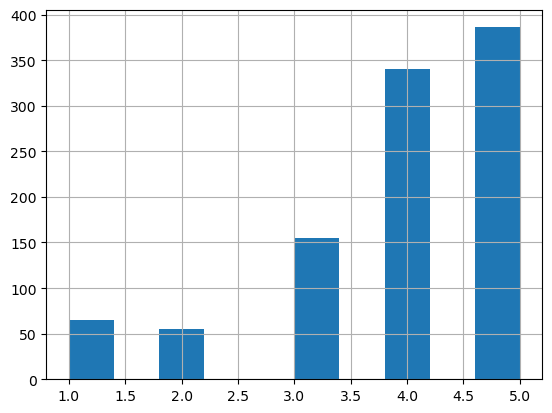

In [45]:
df.rating.hist()
plt.show()

In [46]:
df.sample(10).head()

,rating,text,y
950,5,26 / 2 / 18에 하룻밤을 머물렀다. 장소를 돌보는 부부는 친절하고 도움이되었...,1
911,5,공항에서 가깝고 청결상태도 좋은 호텔입니다. 약간 골목에 위치해 있어 처음 갈 때 ...,1
961,4,"이에 관련된 것을 생각하지 않습니다 호텔 이름을 제외한 초콜릿. 큰 객실, 단정하고...",1
187,5,멋진 제주 섬을 발견하기 위해 5박을 거기에서 보냈다. 이 게스트 하우스는 도시의 ...,1
449,5,안녕하세요. 내가 마지막으로 2015 frien 을 봄. 8pm 에 도착 하다. 이...,1


In [29]:
'''
이진 분류 부분
rating이 4, 5점에 해당되면 긍정적.
rating이 1, 2, 3점에 해당되면 부정적.

이를 새로운 칼럼을 만들어서 긍정적이면 1, 그 외에는 0으로 분류
'''
def rating_to_label(rating):
  if rating > 3:
    return 1
  else:
    return 0
df['y'] = df['rating'].apply(lambda x : rating_to_label(x))

In [30]:
df.head()

,rating,text,y
0,4,여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...,1
1,4,"2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입...",1
2,4,지인에소개로온 호텔 깨끗하고 좋은거같아요 처음에는 없는게 많아 많이 당황했는데 ...,1
3,5,방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...,1
4,5,저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...,1


In [31]:
df.y.value_counts()

1    726
0    275
Name: y, dtype: int64

-----

### 4-2) 데이터셋 분리

In [32]:
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(tf_idf_vect, y, test_size = 0.3)

In [33]:
print(x_train.shape)
print(x_test.shape)

(700, 3599)
(301, 3599)


-----

### 4-3) 모델 학습

##### Logistic Regression 학습

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

lr = LogisticRegression(random_state = 0)
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

##### 분류 결과 평가

In [35]:
accuracy_score(y_test, y_pred)

0.7109634551495017

In [36]:
precision_score(y_test, y_pred)

0.706081081081081

In [37]:
recall_score(y_test, y_pred)

1.0

In [38]:
f1_score(y_test, y_pred)

0.8277227722772277

In [39]:
# y=1과 y=0의 샘플링의 크기가 다르기 때문에 편향된 예측을 함.
# y=1의 크기는 700개, y=0의 크기는 301개임.
# 여기서 y=1로만 찍어도 예측율이 0.7이 됨.
# 따라서 샘플링의 크기를 같게 재조정을 할 필요가 있음.
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_test, y_pred)
print(confmat)

[[  5  87]
 [  0 209]]


-----

### 4-4) 샘플링 재조정

##### 1:1 Sampling

In [40]:
positive_sample_idx = df[df['y']==1].sample(275, random_state=33).index.tolist()
negative_sample_idx = df[df['y']==0].sample(275, random_state=33).index.tolist()

In [41]:
random_idx = positive_sample_idx + negative_sample_idx
x = tf_idf_vect[random_idx]
y = df['y'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [42]:
print(x_train.shape)

(385, 3599)


In [43]:
print(x_test.shape)

(165, 3599)


##### 모델 재학습

In [44]:
lr = LogisticRegression(random_state = 0)
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

##### 분류 결과 평가

In [45]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.7090909090909091
0.6883116883116883
0.6883116883116883
0.6883116883116883


In [46]:
confmat = confusion_matrix(y_test, y_pred)
print(confmat)

[[64 24]
 [24 53]]


-----

## 5) 긍정/부정 키워드 분석

##### Logistic Regression 모델의 coef 분석

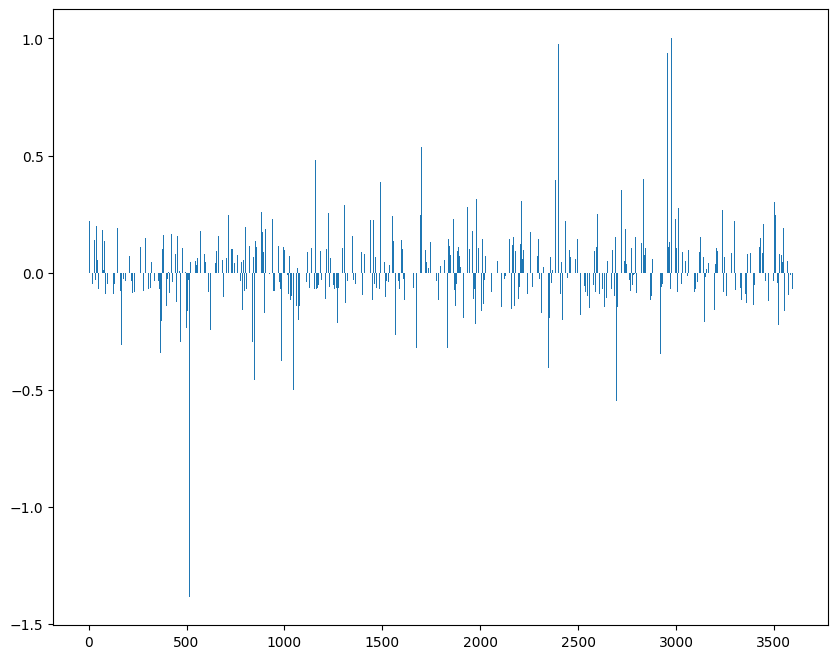

In [47]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])
plt.show()

##### 긍정/부정 키워드 출력

In [48]:
'''
코드 설명
# 위에거는 가장 긍정적인 5개의 리뷰에 대한 정보를 나타냄.
# 아래거는 가장 부정적인 5개의 리뷰에 대한 정보를 나타냄.
# 왼쪽 숫자가 커질수록 긍정적, 작아질수록 부정적.
# (1.2523469722092242, 2977)에서 2977번째 인덱스는 1.252 정도로 가장 긍정적이라는 의미.
# (-1.0217428474064871, 1293)에서 1293번째 인덱스는 -1.022정도로 가장 부정적이라는 의미.

함수 설명
enumerate() = 반복문 사용 시 몇번째 반복문인지 인덱스 번호와 해당 원소를 튜플형태로 반환
'''
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

[(1.0050872928662538, 115), (1.001632294317843, 2977), (0.978036033988598, 2400), (0.9383210519466145, 2957), (0.8262472536538512, 1247)]
[(-0.8177853081182115, 2966), (-0.8211983432967477, 1463), (-0.8766614387771018, 1293), (-0.8960279271946049, 567), (-1.3853503047132543, 515)]


In [49]:
# 위에거는 상위 n개의 긍정적인 인덱스, 아래거는 상위 n개의 부정적인 인덱스
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=False)
coef_pos_index

[(1.0050872928662538, 115),
 (1.001632294317843, 2977),
 (0.978036033988598, 2400),
 (0.9383210519466145, 2957),
 (0.8262472536538512, 1247),
 (0.7993237569378631, 26),
 (0.7897605341204815, 1384),
 (0.762393330067025, 956),
 (0.7565787185836198, 2779),
 (0.7208361701463416, 131),
 (0.6310217628437421, 1809),
 (0.6271033971755179, 1217),
 (0.6183853644640519, 246),
 (0.6084189272700093, 385),
 (0.5965753215954677, 1805),
 (0.5896366527408174, 1853),
 (0.5690450536188493, 2455),
 (0.5606633273229104, 2988),
 (0.5455018099623767, 106),
 (0.5361159747526584, 1700),
 (0.5305426095539519, 578),
 (0.5189139471369806, 2771),
 (0.4929789467273374, 981),
 (0.49115677084534054, 826),
 (0.4851352852840558, 3060),
 (0.48154608774834384, 1159),
 (0.48002130732528253, 680),
 (0.47698676213671815, 2680),
 (0.46212173014905816, 3453),
 (0.4525827972001986, 2082),
 (0.44732067783148266, 136),
 (0.4442049333122624, 154),
 (0.4366185658713124, 300),
 (0.4276781902120451, 2595),
 (0.4186485555731041, 2311

In [50]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}

In [51]:
# 51번 라인에 나온 인덱스 2997번, 385번을 단어로 바꾸는 과정.
for coef in coef_pos_index[:15]:
    print(invert_index_vectorizer[coef[1]], coef[0])

거리 1.0050872928662538
추천 1.001632294317843
이용 0.978036033988598
최고 0.9383210519466145
버스 0.8262472536538512
가성 0.7993237569378631
분위기 0.7897605341204815
맛집 0.762393330067025
주차 0.7565787185836198
걱정 0.7208361701463416
시설 0.6310217628437421
방문 0.6271033971755179
공간 0.6183853644640519
근처 0.6084189272700093
시내 0.5965753215954677


In [52]:
for coef in coef_neg_index[:15]:
    print(invert_index_vectorizer[coef[1]], coef[0])

냄새 -1.3853503047132543
다른 -0.8960279271946049
별로 -0.8766614387771018
사람 -0.8211983432967477
최악 -0.8177853081182115
에어컨 -0.6991791710864806
제공 -0.5459917898442792
대해 -0.5242749773350048
보이 -0.5184115879169581
모기 -0.5050672341762737
모텔 -0.5024531045560248
그냥 -0.5021858054472499
방음 -0.4908393282023604
전혀 -0.4865199119525782
확인 -0.4842511121719878
